Copy of 12 with MAE

In [1]:
AEversion = '13'

In [2]:
import numpy as np
import os, sys, pickle
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [3]:
import gpustat
try:
    gpustat.print_gpustat()
except:
    pass

imperium-sm.hep.caltech.edu  Wed Jul 17 05:11:20 2019
[0] GeForce GTX 1080 | 37'C,  10 % |  2560 /  8119 MB | ocerri(2549M)
[1] GeForce GTX 1080 | 25'C,   0 % |  3497 /  8119 MB | ocerri(3029M) ocerri(457M)
[2] GeForce GTX 1080 | 25'C,   0 % |    10 /  8119 MB |
[3] GeForce GTX 1080 | 69'C,  95 % |  1782 /  8119 MB | 3041(1771M)
[4] GeForce GTX 1080 | 25'C,   0 % |    11 /  8119 MB |
[5] GeForce GTX 1080 | 24'C,   0 % |    11 /  8119 MB |
[6] GeForce GTX 1080 | 24'C,   0 % |    11 /  8119 MB |
[7] GeForce GTX 1080 | 42'C,   0 % |  1158 /  8119 MB | ocerri(1147M)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
sys.path.append('../lib')
from progressBar import ProgressBar
from utils import EarlyStopping, createROC_curve, ELU_ProbNorm

In [6]:
dnd = []

## Get the dataset

In [7]:
from dataLoaders import ParticleDataset

In [8]:
dataset = ParticleDataset(template='../data/20190708_50part_PtOrder_v2/{}.npy', N_part=30, N_features=5)

In [9]:
dataset.loadTrainSM(N_train_max=1e7)
dataset.charge(dataset.SMMix_train)

Fetching Wlnu
Fetching qcd
Fetching Zll
Fetching ttbar
QCD is limiting, using it for both val and split
Expected 3.38M train
Expected 3.38M val

Loading Wlnu
Reloading QCD for validation
Loading Zll
Loading ttbar
+--------+----------+-------+-------+
| Sample | Evts tot | Train |  Val  |
+--------+----------+-------+-------+
|  Wlnu  |  4000k   | 2000k | 2000k |
|  qcd   |  1166k   | 1142k | 1142k |
|  Zll   |  1000k   |  226k |  226k |
| ttbar  |  1000k   |  10k  |  10k  |
+--------+----------+-------+-------+
Tot training 3.38 M
Tot val 3.38 M


In [10]:
dataset.loadValidationSamples('BSM')

Loading Ato4l (47.7k)
Loading leptoquark (273.6k)
Loading hToTauTau (681.8k)
Loading hChToTauNu (338.5k)


## Define the model

In [11]:
class AEDenseNet(nn.Module):
    def __init__(self, N_part, N_features, dim_hidden, dim_latent, verbose = False):
        super(AEDenseNet, self).__init__()
        self.verbose = verbose
        
        self.No = N_part
        self.p = N_features
        self.Nk = dim_latent
        
        self.encoder_modules = nn.ModuleDict({
            'PhiE': self.build_dense(dim_in=self.p*self.No,
                                   dim_out=self.Nk,
                                   dim_hidden=dim_hidden)
        })
        
        
        self.decoder_modules = nn.ModuleDict({
            'PhiD': self.build_dense(dim_in=self.Nk,
                                   dim_out=self.p*self.No,
                                   dim_hidden=dim_hidden),
            'ChargeDec': self.build_dense(dim_in=2,
                                   dim_out=3),
            'pdgIdDec': self.build_dense(dim_in=2,
                                   dim_out=5)
        })
        
        
        self.onGPU = False
          
    def build_dense(self, dim_in, dim_out, dim_hidden=0):
        if dim_hidden:
            net = nn.Sequential(
                                nn.Linear(dim_in, dim_hidden),
                                nn.ReLU(),
                                nn.Linear(dim_hidden, dim_hidden),
                                nn.ReLU(),
                                nn.Linear(dim_hidden, dim_out),
                              )
        else:
            d_avg = int(0.5*(dim_in + dim_out))
            net = nn.Sequential(
                                nn.Linear(dim_in, d_avg),
                                nn.ReLU(),
                                nn.Linear(d_avg, dim_out),
                              )
        return net
        
    def encode(self, x):
        z_raw = self.encoder_modules['PhiE'](x.contiguous().view(-1, self.p*self.No))
        z = F.hardtanh(z_raw, min_val=-5, max_val=5)
        return z
    
    def decode(self, z):
        x_raw = self.decoder_modules['PhiD'](z).view(-1, self.No, self.p)
        
        # --- Formatting x ----
        # pt
        pt = 1. + F.elu(x_raw[:,:,0]).view(-1, self.No, 1)
        # eta
        eta = F.hardtanh(x_raw[:,:,1], min_val=-5, max_val=5).view(-1, self.No, 1)
        # phi
        phi = torch.fmod(torch.abs(x_raw[:,:,2]), 6.2831853072).view(-1, self.No, 1) - 3.14159265359
        # charge
        charge_cat = ELU_ProbNorm(self.decoder_modules['ChargeDec'](x_raw[:,:,3:].view(-1,2)), dim=1).view(-1, self.No, 3)
        # pId
        pId_cat = ELU_ProbNorm(self.decoder_modules['pdgIdDec'](x_raw[:,:,3:].view(-1,2)), dim=1).view(-1, self.No, 5)
        
        x = torch.cat((pt, eta, phi, charge_cat, pId_cat), 2)
        return x
        
    
    def forward(self, x):
        z = self.encode(x)
        x_prime = self.decode(z)
        return x_prime
    
    def initWeights(self):
        def weights_init(M):
            if hasattr(M, 'weight'):
                nn.init.xavier_normal_(M.weight.data)
        
        self.apply(weights_init)
    
    def useGPU(self, N_GPU=1):
        if torch.cuda.is_available():
            print('Current device: {} ({} available)'.format(torch.cuda.current_device(), 
                                                             torch.cuda.device_count()))
            os.environ['CUDA_VISIBLE_DEVICES'] = str(N_GPU)
            self.N_GPU = N_GPU
            torch.cuda.empty_cache()
            self.cuda(N_GPU)
            gpustat.print_gpustat()
            
            self.onGPU = True
        else: 
            print('GPU not available')

In [12]:
Latent_dimension = 40
Hidden_dimension = 100

model = AEDenseNet(
                   N_part=dataset.inputs.shape[1],
                   N_features=dataset.inputs.shape[2],
                   dim_hidden=Hidden_dimension,
                   dim_latent=Latent_dimension
                  )

print(model)
trainablePars = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('\nTrainable parameters:', trainablePars)

# model.initWeights()

AEDenseNet(
  (encoder_modules): ModuleDict(
    (PhiE): Sequential(
      (0): Linear(in_features=150, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU()
      (4): Linear(in_features=100, out_features=40, bias=True)
    )
  )
  (decoder_modules): ModuleDict(
    (ChargeDec): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2, out_features=3, bias=True)
    )
    (PhiD): Sequential(
      (0): Linear(in_features=40, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU()
      (4): Linear(in_features=100, out_features=150, bias=True)
    )
    (pdgIdDec): Sequential(
      (0): Linear(in_features=2, out_features=3, bias=True)
      (1): ReLU()
      (2): Linear(in_features=3, out_features=5, bias=True)
    )
  )
)

Trainable parameters: 58634


In [13]:
model.useGPU(7)

Current device: 0 (8 available)
imperium-sm.hep.caltech.edu  Wed Jul 17 05:11:58 2019
[0] GeForce GTX 1080 | 37'C,   1 % |  2560 /  8119 MB |
[1] GeForce GTX 1080 | 25'C,   0 % |  3497 /  8119 MB | ocerri(3029M)
[2] GeForce GTX 1080 | 25'C,   0 % |    10 /  8119 MB |
[3] GeForce GTX 1080 | 68'C,  94 % |  1782 /  8119 MB | 3041(1771M)
[4] GeForce GTX 1080 | 25'C,   0 % |    11 /  8119 MB |
[5] GeForce GTX 1080 | 24'C,   0 % |    11 /  8119 MB |
[6] GeForce GTX 1080 | 24'C,   0 % |    11 /  8119 MB |
[7] GeForce GTX 1080 | 38'C,   4 % |  1615 /  8119 MB | ocerri(1147M) ocerri(457M)


## Loss

In [14]:
def criterion(x_in, x_out, reduction='mean'):
    # Gaussian
    NLL_gauss = torch.abs(x_in[:,:,:3] - x_out[:,:,:3])
    
    #Cat cross entropy charge
    aux = torch.log(x_out[:,:,3:6]).view(-1, 3)
    NLL_charge = F.nll_loss(aux, 1+x_in[:,:,3].view(-1).long(), reduction='none').view(-1, x_in.shape[1], 1)
    
    #Cat cross entropy pId
    aux = torch.log(x_out[:,:,6:]).view(-1, 5)
    NLL_pId = F.nll_loss(aux, x_in[:,:,4].view(-1).long(), reduction='none').view(-1, x_in.shape[1], 1)
    
    NLL_tot = torch.cat((NLL_gauss, NLL_charge, NLL_pId), 2)
    NLL_perEvent = torch.mean(NLL_tot, dim=1)
    
    if reduction == 'mean':
        NLL_mean = torch.mean(NLL_perEvent, dim=0)
        return torch.sum(NLL_mean), NLL_mean.cpu().detach().numpy()
    elif reduction == 'none':
        return torch.sum(NLL_perEvent, dim=1)
    else:
        raise

## Training

In [15]:
training_params = {'batch_size': 1000,
                   'shuffle': True,
                   'num_workers': 3
                  }

max_epochs = 1000

eval_params = {'batch_size': 20000,
               'num_workers': 3
              }

In [16]:
# torch.autograd.set_detect_anomaly(True);

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min',
                              factor=0.3,
                              patience=3,
                              verbose=1,
                              threshold=1e-4,
                              cooldown=2,
                              min_lr=1e-7
                             )

# Early stopping
earlyStopping = EarlyStopping(patient=10)

In [18]:
train_loss = []
BSM_eff = {'ep': []}
for n in dataset.BSM_names:
    BSM_eff[n] = []

loss_history = {'train': [], 'val': [], 'val_feat': []}
optimizer.zero_grad()
try:
    for epoch in range(max_epochs):
        batch_loss = []

        #### ---- Training ---- ####
        model.train()
        dataset.charge(dataset.SMMix_train)
        train_data_iter = torch.utils.data.DataLoader(dataset, **training_params)
        pb = ProgressBar(len(train_data_iter), percentPrecision=5, headLabel='Epoch {}: '.format(epoch))
        for local_x, _ in train_data_iter:
            if model.onGPU:
                local_x = local_x.cuda(model.N_GPU)

            x_prime = model(local_x)        
            loss, _ = criterion(local_x, x_prime)
            if np.isnan(loss.item()) or np.isinf(loss.item()):
                print('Invalid training loss!!!')
                raise NameError('LossNAN')
            batch_loss.append(loss.item())

            tail_label = 'Loss: {:2.2e}'.format(loss.item())
            if len(loss_history['train']) > 0:
                tail_label += ' ({:2.2e})'.format(loss.item() - loss_history['train'][-1][-1])
            pb.show(len(batch_loss)-1, tail_label=tail_label)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        aux_loss = 0
        N_batches = 0
        for local_x, _ in train_data_iter:
            if model.onGPU:
                local_x = local_x.cuda(model.N_GPU)
            x_prime = model(local_x)
            loss, _ = criterion(local_x, x_prime)
            aux_loss += loss.item()
            N_batches += 1
        batch_loss.append(aux_loss/N_batches)

        printout = 'Loss: {:2.2e}'.format(batch_loss[-1])
        if len(loss_history['train']) > 0:
            printout += ' - Delta: {:2.2e}'.format(batch_loss[-1] - loss_history['train'][-1][-1])
        if len(loss_history['train']) > 1:
            d2L_de2 = batch_loss[-1] - 2*loss_history['train'][-1][-1] + loss_history['train'][-2][-1]
            printout +=' - Trend: {:2.2e}'.format(d2L_de2)
        print(printout)

        loss_history['train'].append(batch_loss)

        #### ---- Validation ---- ####
        dataset.charge(dataset.SMMix_val)
        val_data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
        aux_loss = 0
        aux_feat = np.zeros((5))
        N_batches = 0
        for local_x, _ in val_data_iter:
            if model.onGPU:
                local_x = local_x.cuda(model.N_GPU)
            x_prime = model(local_x)
            loss, NLL_feat = criterion(local_x, x_prime)
            if np.isnan(loss.item()) or np.isinf(loss.item()):
                print('Invalid validation loss!!!')
                raise NameError('LossNAN')
            aux_loss += loss.item()
            aux_feat += NLL_feat
            N_batches += 1
        loss_history['val'].append(aux_loss/N_batches)
        loss_history['val_feat'].append(aux_feat/N_batches)
        printout = 'Val Loss: {:2.2e}'.format(loss_history['val'][-1])
        printout += ' Pt:{:.2f} - Eta:{:.2f} - Phi:{:.2f} - Charge:{:.2f} - pId:{:.2f}'.format(*loss_history['val_feat'][-1])
        print(printout)
        if epoch > 0:
            if loss_history['val'][-1] < np.min(loss_history['val']):
                print('[INFO]: Saving best model')
                torch.save(model.state_dict(), 'data/model_state_dict_dAE_v'+AEversion+'_best.pkl')

        print('')
        if not earlyStopping.check(loss_history['val'][-1]):
            break

        scheduler.step(batch_loss[-1])
        
        #### ---- Periodic save model ---- ####
        if epoch%50 == 0:
            torch.save(model.state_dict(), 'data/model_state_dict_dAE_v'+AEversion+'_epoch{}.pkl'.format(epoch))

        #### ---- Anomaly Detection monitor ---- ####
        if epoch%10 == 0:
            print('------------ Anomaly Detection monitor ------------')
            BSM_eff['ep'].append(epoch)
            dataset.loss['SMMix'] = np.zeros((0))

            pb = ProgressBar(len(val_data_iter), percentPrecision=5, headLabel='SM Mix: ')
            for i, (local_x, _) in enumerate(val_data_iter):
                    pb.show(i)
                    if model.onGPU:
                        local_x = local_x.cuda(model.N_GPU)

                    x_prime = model(local_x)
                    loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
                    dataset.loss['SMMix'] = np.concatenate((dataset.loss['SMMix'], loss))

            p_SM = np.logspace(base=10, start=-5, stop=-3, num=3)
            if not 'p_SM' in BSM_eff.keys():
                BSM_eff['p_SM'] = p_SM
            q_SM = np.quantile(dataset.loss['SMMix'], 1-p_SM)

            table = PrettyTable(['SM Mix'] + list(map(lambda x: '{:1.2e}'.format(x), p_SM)))

            for n in dataset.BSM_names:
                dataset.loss[n] = np.zeros((0))

                dataset.charge(dataset.valSamples[n])
                data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
                pb = ProgressBar(len(data_iter), percentPrecision=5, headLabel=n+': ')
                for i, (local_x, _) in enumerate(data_iter):
                    pb.show(i)
                    if model.onGPU:
                        local_x = local_x.cuda(model.N_GPU)

                    x_prime = model(local_x)
                    loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
                    dataset.loss[n] = np.concatenate((dataset.loss[n], loss))

                out = dataset.loss[n] > np.atleast_2d(q_SM).T
                p_BSM = np.float64(np.sum(out, axis=1, dtype=np.float128)/dataset.loss[n].shape[0])
                BSM_eff[n].append(p_BSM)

                table.add_row([n] + list(map(lambda x: '{:1.2e}'.format(x), p_BSM)))
            print(table)                
            print('---------------------------------------------------\n\n')

    model.eval()
    torch.save(model.state_dict(), 'data/model_state_dict_dAE_v'+AEversion+'.pkl');
except NameError:
    if epoch > 0:
        print ('\n\nModel ended up nan. Recovering best model\n')
        model.load_state_dict(torch.load('data/model_state_dict_dAE_v'+AEversion+'_best.pkl'))
    else:
        raise

Epoch 0: [####################]  100% - Tot. time: 36.7 s           
Loss: 7.55e+00
Val Loss: 7.58e+00 Pt:0.33 - Eta:3.63 - Phi:1.75 - Charge:0.87 - pId:0.99

------------ Anomaly Detection monitor ------------
SM Mix: [####################]  100% - Tot. time: 19.6 s
Ato4l: [###]  100% - Tot. time: 0.0 s
leptoquark: [##############]  100% - Tot. time: 1.0 s
hToTauTau: [####################]  100% - Tot. time: 3.5 s
hChToTauNu: [#################]  100% - Tot. time: 1.4 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 2.93e-04 | 1.09e-02 | 8.77e-02 |
| leptoquark | 1.02e-04 | 1.74e-03 | 1.84e-02 |
| hToTauTau  | 8.80e-04 | 6.98e-03 | 3.57e-02 |
| hChToTauNu | 1.51e-03 | 1.05e-02 | 4.63e-02 |
+------------+----------+----------+----------+
---------------------------------------------------


Epoch 1: [####################]  100% - Tot. time: 38.1 s                       
Loss:

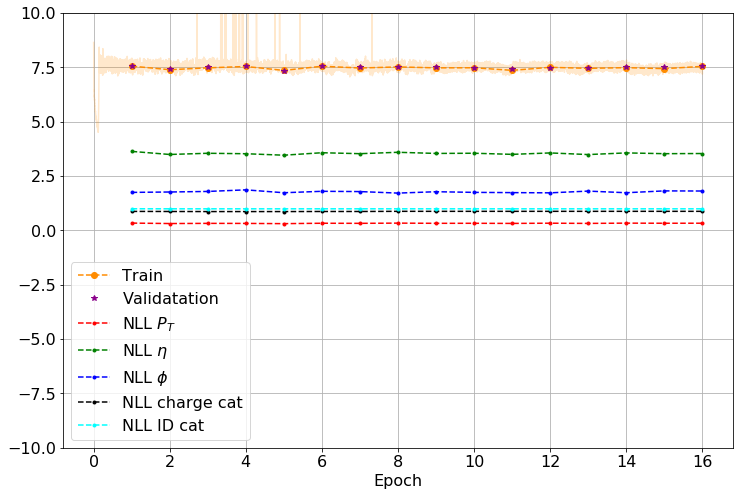

In [19]:
loss_history['train'] = np.array(loss_history['train'])
matplotlib.rcParams.update({'font.size': 16})

f = plt.figure(figsize=(12,8))

train_loss_flat = loss_history['train'].flatten()
x = np.arange(1, train_loss_flat.shape[0]+1) * float(loss_history['train'].shape[0])/train_loss_flat.shape[0]
plt.plot(x, train_loss_flat, '-', alpha=0.2, color='darkorange')

x = np.arange(1, loss_history['train'].shape[0]+1)
plt.plot(x, loss_history['train'][:,-1], 'o--', label='Train', color='darkorange')
plt.plot(x, loss_history['val'], '*', label='Validatation', color='darkmagenta')

lval_feat = np.array(loss_history['val_feat'])
plt.plot(x, lval_feat[:,0], '--.', label='NLL $P_T$', color='r')
plt.plot(x, lval_feat[:,1], '--.', label='NLL $\eta$', color='g')
plt.plot(x, lval_feat[:,2], '--.', label='NLL $\phi$', color='b')
plt.plot(x, lval_feat[:,3], '--.', label='NLL charge cat', color='k')
plt.plot(x, lval_feat[:,4], '--.', label='NLL ID cat', color='cyan')

plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='best')
# plt.yscale('log')
plt.ylim(-10, 10)

f.savefig('plots/TrainingHistory_dAE_v'+AEversion+'.png')

f = open('data/TrainingHistory_dAE_v'+AEversion+'.pkl', 'wb')
pickle.dump(loss_history, f)
f.close()

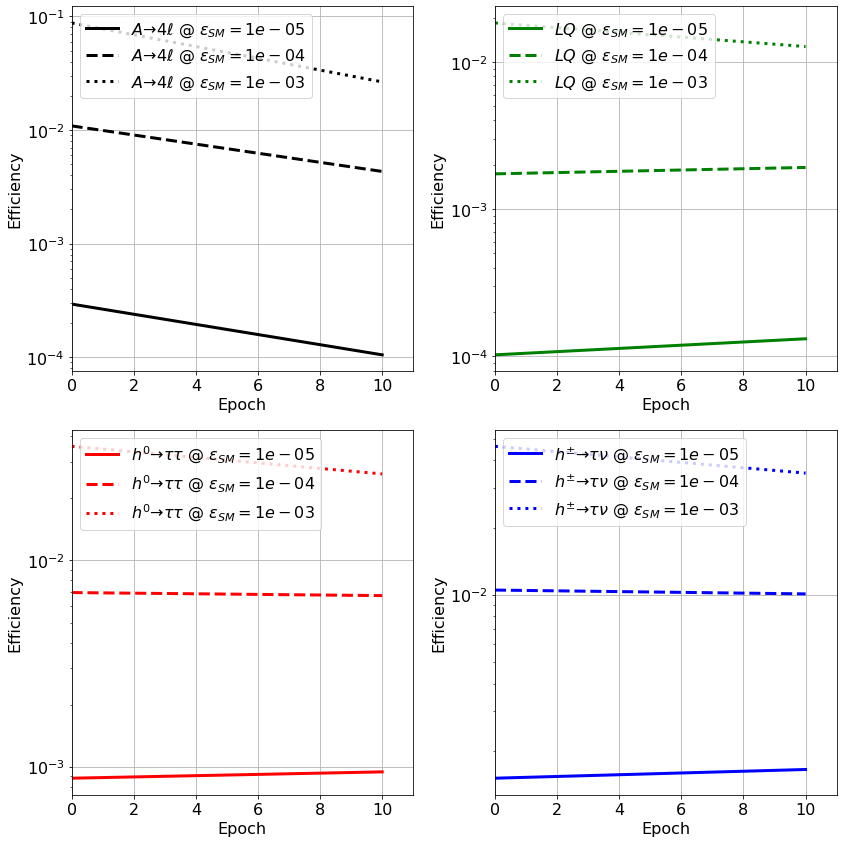

In [20]:
f, ax_arr = plt.subplots(2,2, figsize=(12,12))
styles = ['-', '--', ':']
x = BSM_eff['ep']
for i, n in enumerate(dataset.BSM_names):  
    ax = ax_arr[int(i/2),i%2]
    
    BSM_eff[n] = np.array(BSM_eff[n])
    
    for j in range(BSM_eff['p_SM'].shape[0]):
#         ax.plot(x, len(x)*[BSM_eff['p_SM'][j]], color='gray', lw=2, linestyle=styles[j])
        ax.plot(x, BSM_eff[n][:,j], 
                color=dataset.process_colors[n], lw=3, linestyle=styles[j], 
                label=dataset.process_labels[n] + ' @ $\epsilon_{{SM}} = {:1.0e}$'.format(BSM_eff['p_SM'][j]))
        
    ax.set_xlim([0, x[-1]+1])
#     ax.set_ylim([1e-6, 5])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Efficiency')
    ax.set_title('')
    ax.set_yscale('log')
    ax.grid()
    
    ax.legend(loc='best')
    
f.tight_layout()

f = open('data/AnomalyDetectionHistory_dAE_v'+AEversion+'.pkl', 'wb')
pickle.dump(BSM_eff, f)
f.close()

In [21]:
# model.load_state_dict(torch.load('data/model_state_dict_dAE_v'+AEversion+'_epoch400.pkl'))

# Convergence check

In [22]:
dataset.charge(dataset.SMMix_val)
x = dataset.inputs
model.eval()
if model.onGPU:
    x_prime = model(torch.from_numpy(x[:10000]).cuda(model.N_GPU)).cpu().detach().numpy()
    z = model.encode(torch.from_numpy(x[:10000]).cuda(model.N_GPU)).cpu().detach().numpy()
else:
    x_prime = model(torch.from_numpy(x[:10000])).cpu().detach().numpy()
    z = model.encode(torch.from_numpy(x[:10000])).cpu().detach().numpy()

### Latent space

/nfshome/ocerri/miniconda2/envs/PartAN/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


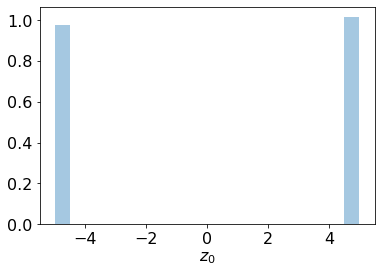

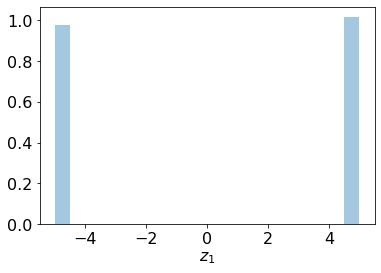

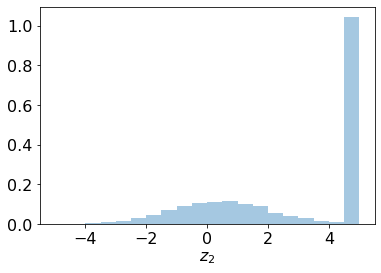

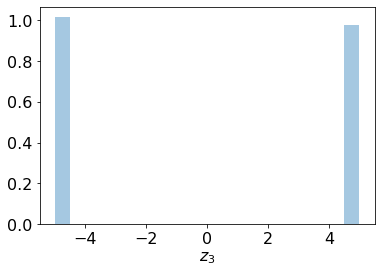

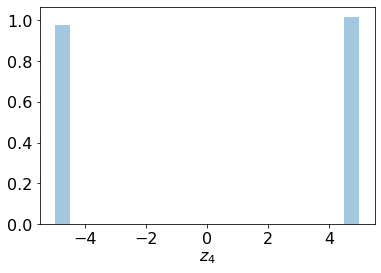

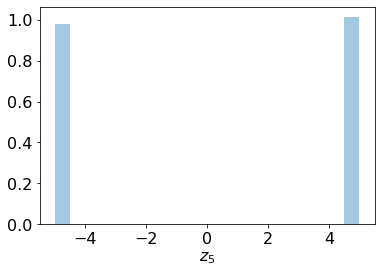

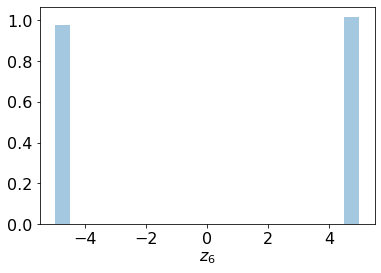

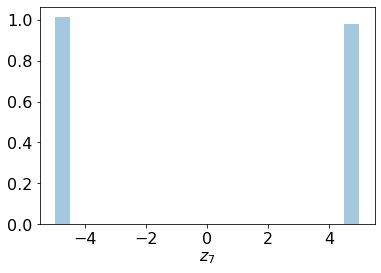

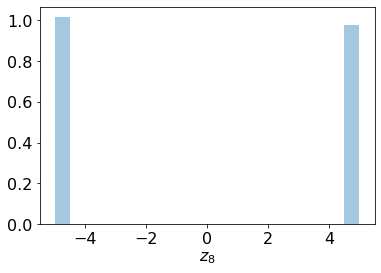

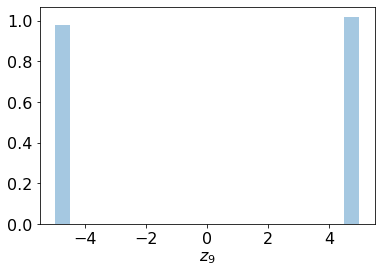

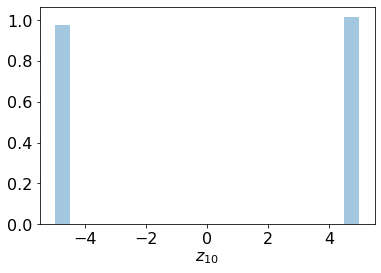

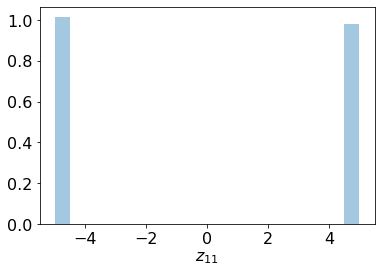

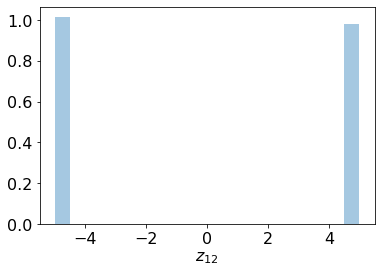

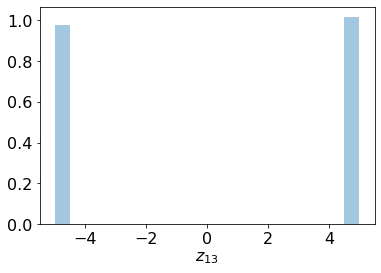

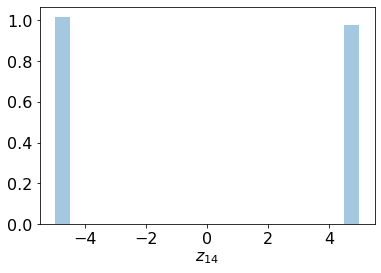

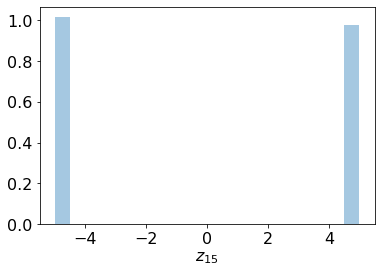

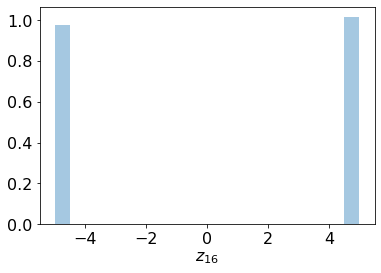

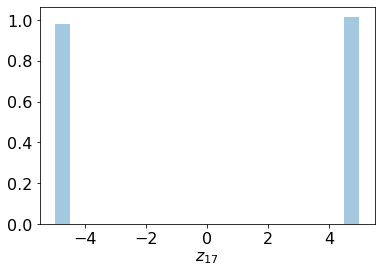

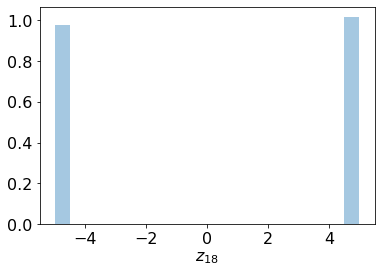

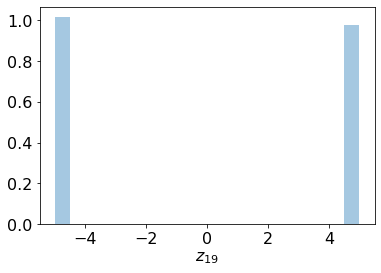

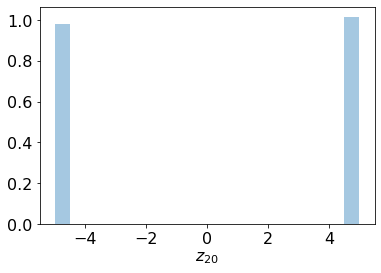

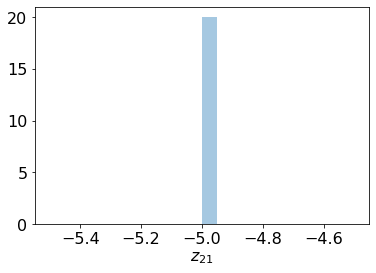

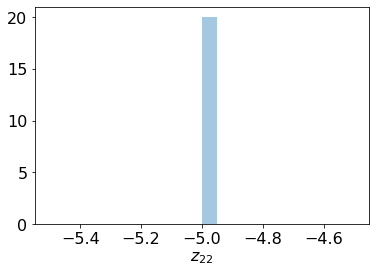

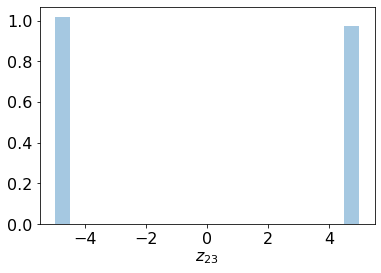

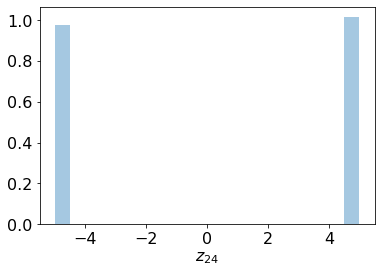

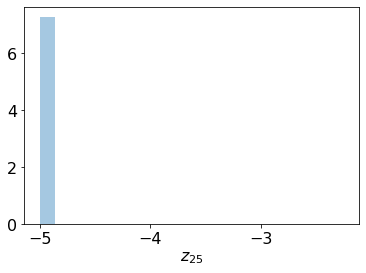

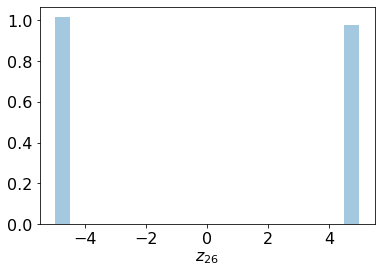

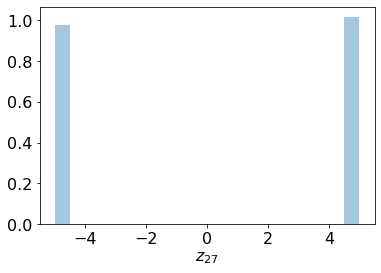

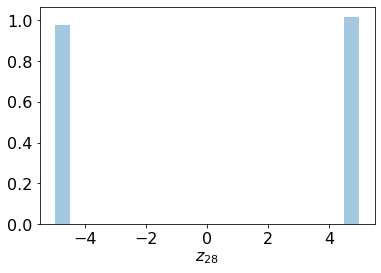

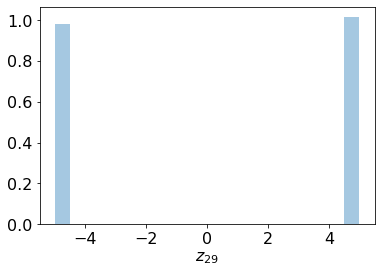

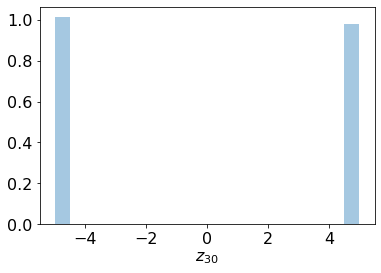

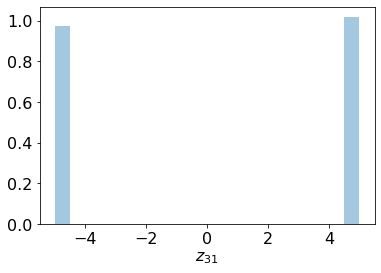

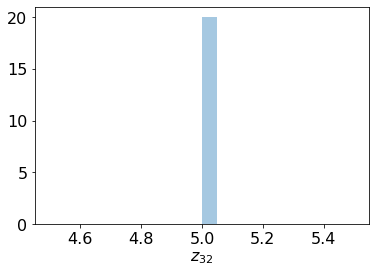

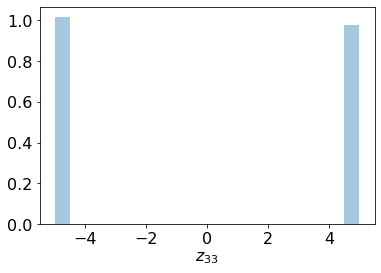

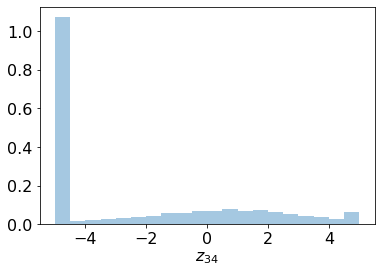

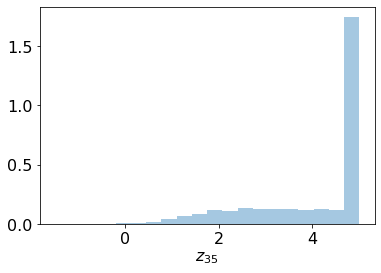

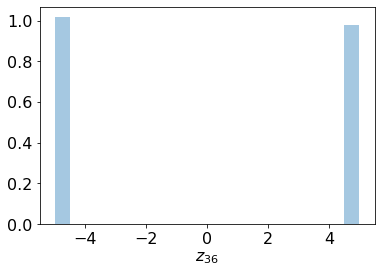

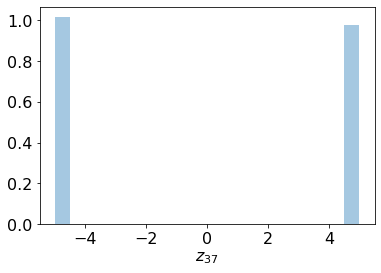

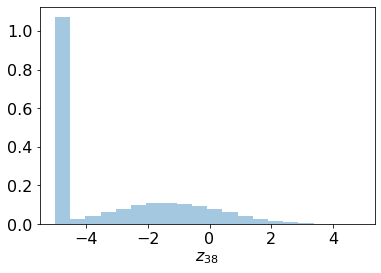

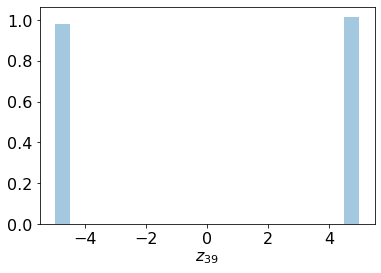

In [23]:
for i in range(z.shape[1]):
    x_aux = z[:,i]
    f = plt.figure(i)
    r = (np.min(x_aux), np.max(x_aux))
    plt.hist(x_aux, bins=20, range=r, alpha=0.4, density=True)
    plt.xlabel('$z_{{{}}}$'.format(i))
    dnd.append(f)

### Output features

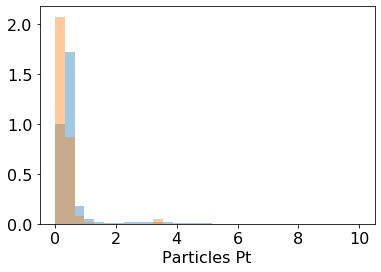

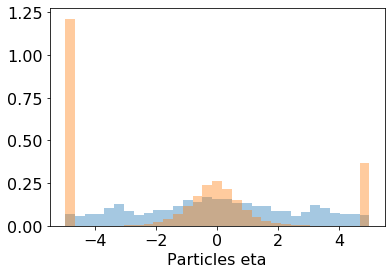

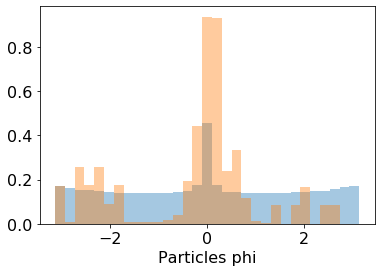

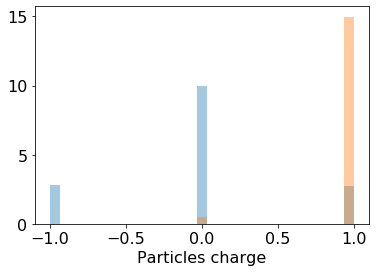

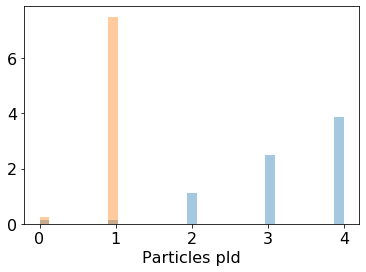

In [24]:
for i in range(x.shape[2]):
    x_aux = x[:,:,i].flatten()
    if i < 3:
        xp_aux = x_prime[:,:,i].flatten()
    elif i==3:
        xp_aux = np.argmax(x_prime[:,:,6:9], axis=2)
        xp_aux = xp_aux.flatten() - 1
    elif i==4:
        xp_aux = np.argmax(x_prime[:,:,9:14], axis=2).flatten()
        
    f = plt.figure(i)
    r = (min(np.min(x_aux), np.min(xp_aux)), max(np.max(x_aux), np.max(xp_aux)))
    if i == 0:
        r = (0,10)
    plt.hist(x_aux, bins=31, range=r, alpha=0.4, density=True)
    plt.hist(xp_aux, bins=31, range=r, alpha=0.4, density=True)
    plt.xlabel('Particles ' + dataset.feature_names[i])
#     plt.yscale('log')
    dnd.append(f)

# Performance evaluation

In [25]:
dataset.loadValidationSamples('SM')

Loading Wlnu (2000.0k)
Loading qcd (1141.9k)
Loading Zll (773.6k)
Loading ttbar (989.9k)
SM Mix limiting stat. sample: qcd (1.14M)
SM validation weights
[('Wlnu', 0.99999921893491114253), ('qcd', 1.0), ('Zll', 0.29257605781977745954), ('ttbar', 0.010238898454774046649)]


In [26]:
model.eval()
for n in list(dataset.valSamples.keys()) + ['SMMix']:
    dataset.loss[n] = np.zeros((0))
    if n == 'SMMix':
        dataset.charge(dataset.SMMix_val)
    else:
        dataset.charge(dataset.valSamples[n])
    
    data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
    pb = ProgressBar(len(data_iter), percentPrecision=5, headLabel=n+': ')
    for i, (local_x, _) in enumerate(data_iter):
        pb.show(i)
        if model.onGPU:
            local_x = local_x.cuda(model.N_GPU)
            
        x_prime = model(local_x)
        loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
        dataset.loss[n] = np.concatenate((dataset.loss[n], loss))

Ato4l: [###]  100% - Tot. time: 0.0 s
leptoquark: [##############]  100% - Tot. time: 1.4 s
hToTauTau: [####################]  100% - Tot. time: 4.6 s
hChToTauNu: [#################]  100% - Tot. time: 1.9 s
Wlnu: [####################]  100% - Tot. time: 13.7 s
qcd: [####################]  100% - Tot. time: 7.9 s
Zll: [####################]  100% - Tot. time: 4.8 s
ttbar: [####################]  100% - Tot. time: 6.7 s
SMMix: [####################]  100% - Tot. time: 23.1 s


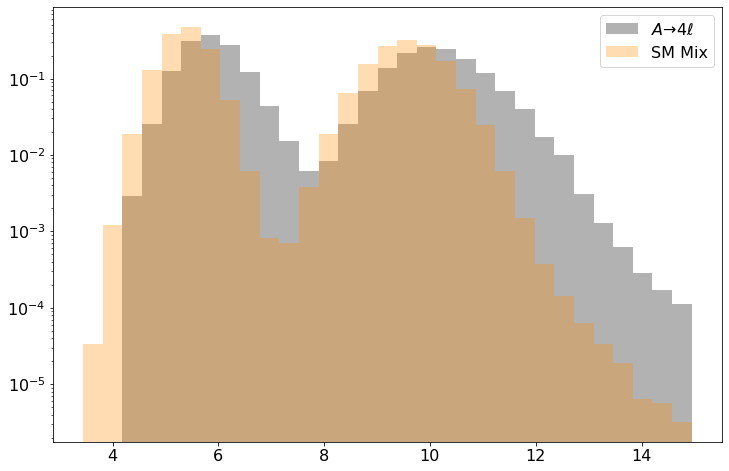

In [27]:
plt.figure(figsize=(12,8))
ra = np.array(list(map(lambda x: [np.min(x), np.quantile(x, 1-1e-3)], dataset.loss.values())))
r = (np.min(ra[:,0]), np.max(ra[:,1]))

for n in ['Ato4l','SMMix']:
    plt.hist(dataset.loss[n], bins=31, range=r,
             density=True,
             color=dataset.process_colors[n], 
             alpha=0.3, 
             label=dataset.process_labels[n])
plt.yscale('log')
plt.legend(loc='best')

In [28]:
dic_ROC = createROC_curve(dataset)
pickle.dump(dic_ROC, open('data/dAE_v{}_ROC_dic.pkl'.format(AEversion), 'wb'))

CumSum accuracy: 1.0000000000000040664


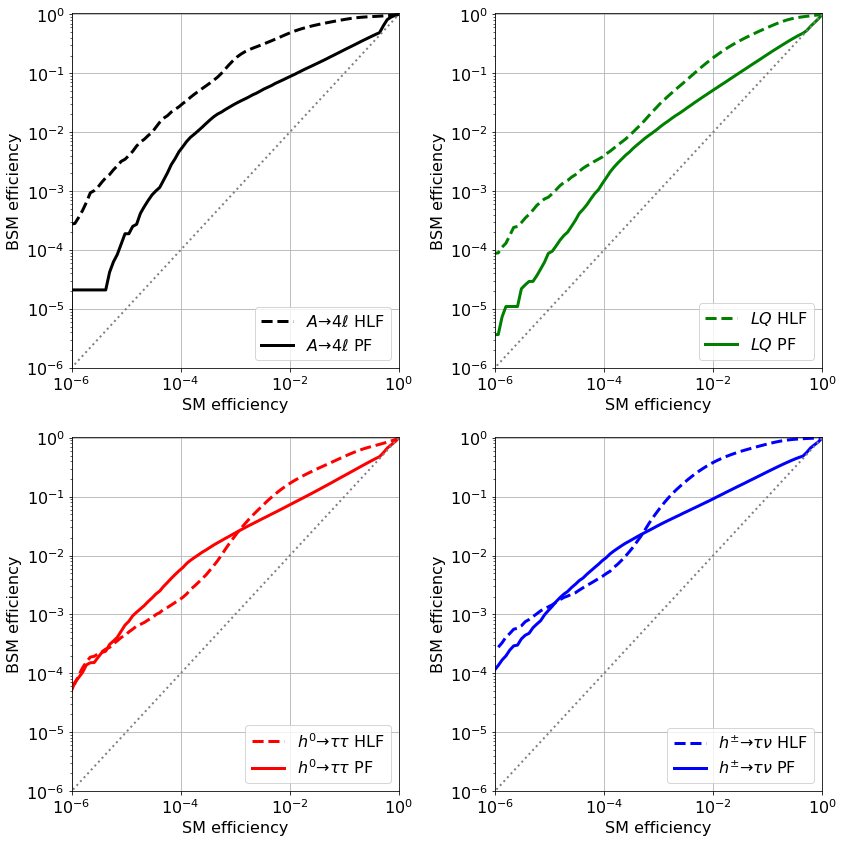

In [29]:
f_ROC, ax_arr = plt.subplots(2,2, figsize=(12,12))
for i, n in enumerate(dataset.BSM_names):
    f = open('../data/HLFref1811-10276_loss/VAE_all-in-one_v71_ROC1_dict_{}.pkl'.format(n), 'br')
    dRef = pickle.load(f, encoding='bytes')
    f.close()
    
    ax = ax_arr[int(i/2),i%2]
    ax.plot(dRef[b'eff_SM'], dRef[b'eff_BSM'], label=dataset.process_labels[n] + ' HLF',
            linestyle='--', lw=3, color=dataset.process_colors[n])
    ax.plot(dic_ROC[n]['eff_SM'], dic_ROC[n]['eff_BSM'], label=dataset.process_labels[n] + ' PF',
            linestyle='-', lw=3, color=dataset.process_colors[n])
    ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle=':')
    ax.set_xlim([1e-6, 1.0])
    ax.set_ylim([1e-6, 1.05])
    ax.set_xlabel('SM efficiency')
    ax.set_ylabel('BSM efficiency')
    ax.set_title('')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid()
    
    ax.legend(loc='lower right')
    
f_ROC.tight_layout()

## Latent dimension clustering

In [30]:
from sklearn.manifold import TSNE

In [31]:
dataset.encoded = {}

for n in dataset.BSM_names:    
    dataset.charge(dataset.valSamples[n][:10000])
    x_in = torch.Tensor(dataset.inputs)
    if model.onGPU:
        x_in = x_in.cuda(model.N_GPU)
    dataset.encoded[n] = model.encode(x_in).cpu().detach().numpy()
    
dataset.charge(dataset.SMMix_val[:10000])
x_in = torch.Tensor(dataset.inputs)
if model.onGPU:
        x_in = x_in.cuda(model.N_GPU)
dataset.encoded['SMMix'] = model.encode(x_in).cpu().detach().numpy()

In [32]:
idx_max = 1000 #np.min(list(map(lambda x: x.shape[0], dataset.encoded.values())))
z_dset = np.zeros((0, model.Nk))

for n in dataset.encoded.keys():
    z_dset = np.concatenate((z_dset, dataset.encoded[n][:idx_max]))
    
z_embedded = TSNE(n_components=2).fit_transform(z_dset)

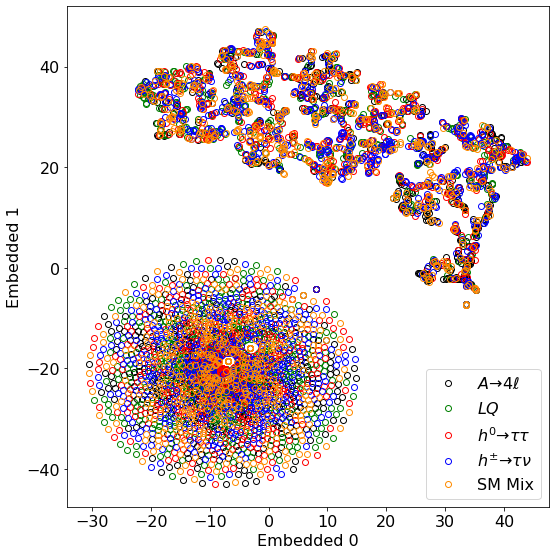

In [33]:
f = plt.figure(figsize=(8,8))

for i, n in enumerate(dataset.encoded.keys()):
#     if not n in ['Ato4l', 'SMMix']: continue
    aux_z = z_embedded[i*idx_max: (i+1)*idx_max]
    plt.plot(aux_z[:,0], aux_z[:,1], 
             'o',
             color=dataset.process_colors[n], 
             mfc='none',
             label=dataset.process_labels[n])
    
plt.xlabel('Embedded 0')
plt.ylabel('Embedded 1')
plt.legend(loc='best')
f.tight_layout()